In [1]:
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import seaborn as sns

In [5]:
import anndata as ad

In [6]:
h5ad_file = '/home/antonl/projects/TSTAMTAXAFCD/PBMC_counts/SS3xpress_PBMC_donor4_and_donor7.h5ad'

In [7]:
adata = sc.read_h5ad(h5ad_file)

In [8]:
adata.obs.groupby('orig.ident').count()

,nCount_RNA,nFeature_RNA,percent.mt,integrated_snn_res.0.8,seurat_clusters,cell_annotation
orig.ident,,,,,,
donor4,3820,3820,3820,3820,3820,3820
donor7,3017,3017,3017,3017,3017,3017


In [9]:
adata

AnnData object with n_obs × n_vars = 6837 × 54684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'integrated_snn_res.0.8', 'seurat_clusters', 'cell_annotation'
    var: 'features', 'integrated_features'
    obsm: 'X_tsne', 'X_umap'
    layers: 'integrated'

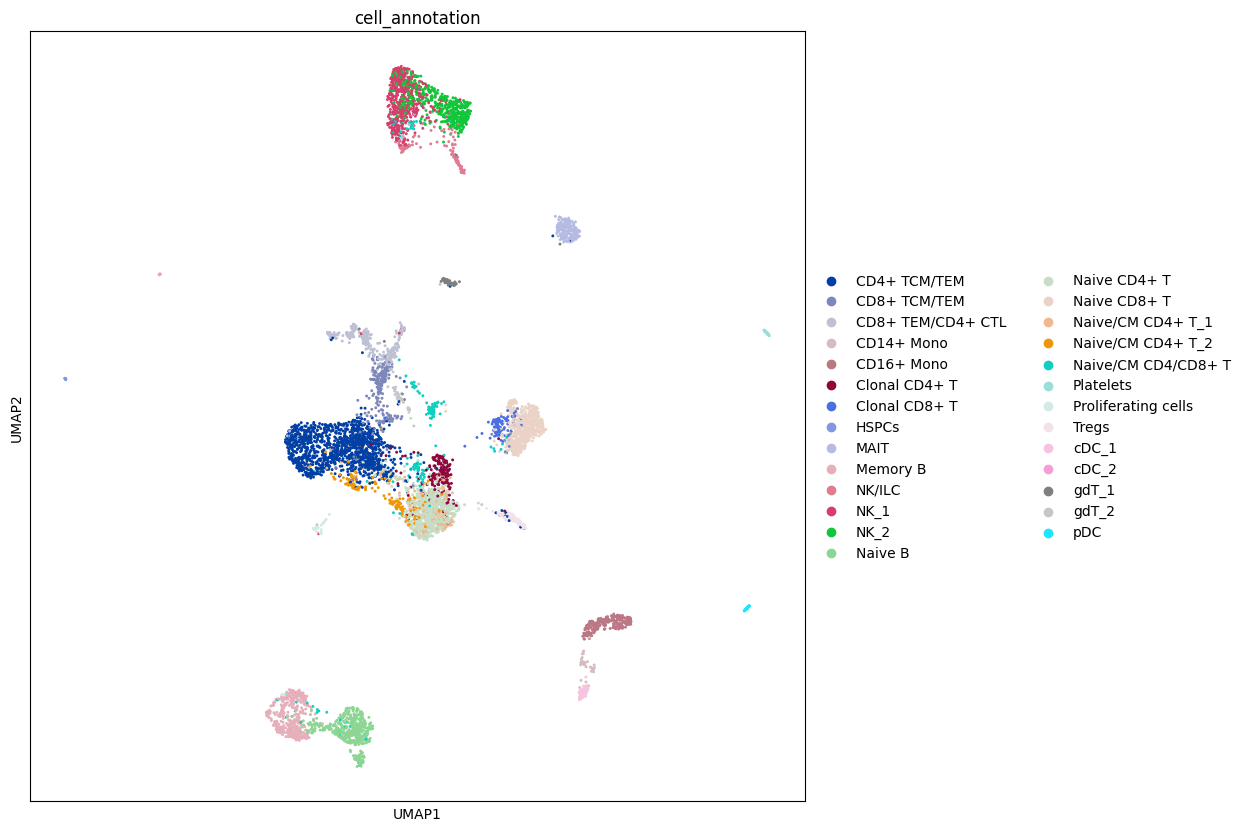

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sc.pl.umap(adata, color='cell_annotation',ax=ax, save='Fig2A.pdf')

In [15]:
XCI_file_donor7 = '/home/antonl/projects/XAlgo/PBMC_donor7/vireo_out/donor_ids.tsv'

XCI_file_donor4 = '/home/antonl/projects/XAlgo/PBMC_donor4/vireo_out/donor_ids.tsv'

XCI_donor7_df = pd.read_csv(XCI_file_donor7, sep='\t', index_col=0)

XCI_donor4_df = pd.read_csv(XCI_file_donor4, sep='\t', index_col=0)

In [17]:
XCI_donor7_df.index = [cell+'_6' for cell in XCI_donor7_df.index]
XCI_donor4_df.index = [cell+'_4' for cell in XCI_donor4_df.index]

In [27]:
XCI_both_df = XCI_donor4_df.append(XCI_donor7_df)

In [30]:
adata.obs = adata.obs.join(XCI_both_df['donor_id'])

In [36]:
XCI_count_per_donor = adata.obs.groupby('orig.ident').apply(lambda df: df.groupby('donor_id').count())['cell_annotation'].reset_index()

In [41]:
XCI_count_per_donor.columns = ['Donor', 'XCI', 'Count']

In [48]:
XCI_count_per_donor.groupby('Donor').sum()

,Count
Donor,
donor4,3820
donor7,3017


In [49]:
XCI_count_per_donor

,Donor,XCI,Count
0,donor4,donor0,1153
1,donor4,donor1,2641
2,donor4,unassigned,26
3,donor7,donor0,1988
4,donor7,donor1,1025
5,donor7,unassigned,4


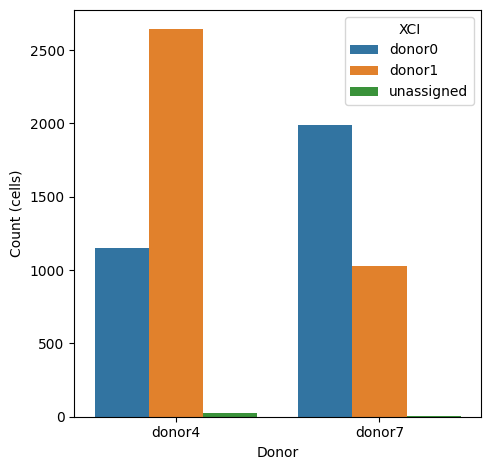

In [46]:
g = sns.barplot(x='Donor', y='Count', hue='XCI', data=XCI_count_per_donor)
g.set_xlabel('Donor')
g.set_ylabel('Count (cells)')
g.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Fig2B.pdf')
plt.show()

In [53]:
XCI_count_per_cell_type = adata.obs.groupby('orig.ident').apply(lambda df: df.groupby('donor_id').apply(lambda df2: df2.groupby('cell_annotation').count()))[['seurat_clusters']].reset_index()

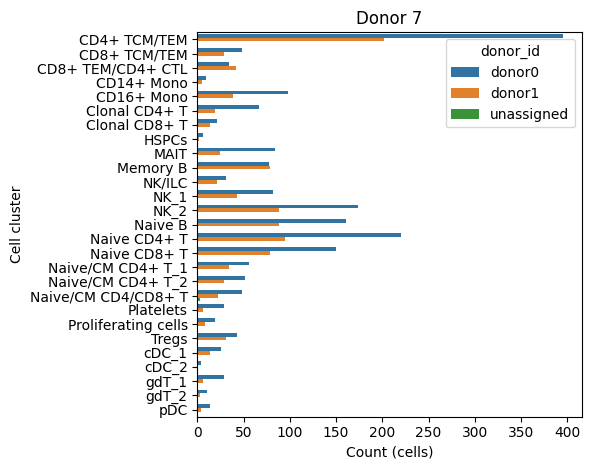

In [59]:
g = sns.barplot(x='seurat_clusters', y='cell_annotation', hue='donor_id', data=XCI_count_per_cell_type[XCI_count_per_cell_type['orig.ident'] == 'donor7'])
g.set_title('Donor 7')
g.set_ylabel('Cell cluster')
g.set_xlabel('Count (cells)')
g.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Supp_Fig_3A_Donor_7.pdf')
plt.show()

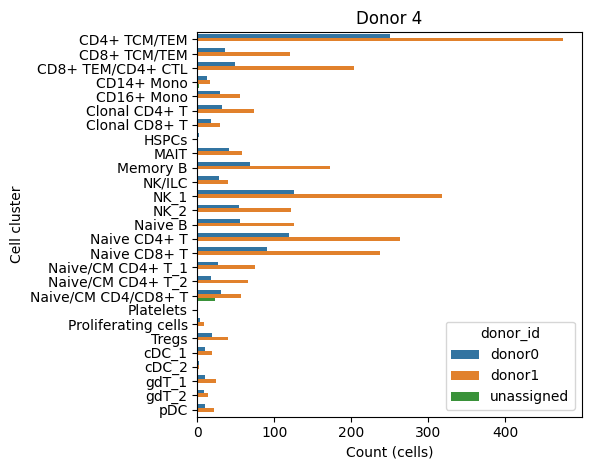

In [60]:
g = sns.barplot(x='seurat_clusters', y='cell_annotation', hue='donor_id', data=XCI_count_per_cell_type[XCI_count_per_cell_type['orig.ident'] == 'donor4'])
g.set_title('Donor 4')
g.set_ylabel('Cell cluster')
g.set_xlabel('Count (cells)')
g.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Supp_Fig_3A_Donor_4.pdf')
plt.show()

In [104]:
adata_donor7 = adata[adata.obs['orig.ident'] == 'donor7']

In [105]:
adata_donor7.obs_names = [cell.split('_')[0] for cell in adata_donor7.obs_names]

/home/nbserver/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:873: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "obs")


In [63]:
import cospar as cs

In [389]:
mut_prob_df = pd.read_csv('Donor7_clonal_mt_mutations.csv', index_col=0)

In [390]:
mut_prob_df = mut_prob_df.reindex(adata_donor7.obs.index).dropna()

In [391]:
adata_donor7.obs['time_info'] = 'Now'

In [392]:
adata_cospar = cs.pp.initialize_adata_object(
    adata=adata_donor7,
    time_info=adata_donor7.obs['time_info']
)

Time points with clonal info: ['Now']


In [393]:
mut_clone_df = pd.DataFrame()
for mut, mut_col in mut_prob_df.iteritems():
    bla_df = pd.DataFrame(mut_col.index[mut_col])
    bla_df.columns = ['Cell_ID']
    bla_df['Cell_ID'] = ['_'.join(cell.split('_')[::-1]) for cell in bla_df['Cell_ID']]
    bla_df['Clone_ID'] = mut
    mut_clone_df = mut_clone_df.append(bla_df)

In [742]:
top_12 = mut_clone_df.groupby('Clone_ID').count().sort_values('Cell_ID')[-12:].index

In [743]:
mut_clone_top_12_df = mut_clone_df[mut_clone_df.apply(lambda row: row['Clone_ID'] in top_12 , axis=1)]

In [748]:
mut_clone_top_12_df = mut_clone_top_12_df.drop([60])

In [749]:
mut_clone_top_12_df.index = mut_clone_top_12_df['Cell_ID']

In [751]:
clone_list = []
for cell in adata_cospar.obs.index:
    if cell in mut_clone_top_12_df.index:
        clone_list.append(mut_clone_top_12_df.loc[cell]['Clone_ID'])
    else:
        clone_list.append('Gray')

In [753]:
adata_cospar.obs['clone_viz'] = clone_list

In [394]:
cs.pp.get_X_clone(adata_cospar, mut_clone_df["Cell_ID"], mut_clone_df["Clone_ID"])

100%|██████████| 702/702 [00:00<00:00, 11349.28it/s]


In [395]:
adata_cospar.obs['state_info'] = adata_cospar.obs['cell_annotation']

In [396]:
mut_count_series = mut_clone_df.groupby('Cell_ID').count()['Clone_ID']
mut_count_series.name = 'Mutation Count'

In [397]:
adata_cospar

AnnData object with n_obs × n_vars = 3017 × 54684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'integrated_snn_res.0.8', 'seurat_clusters', 'cell_annotation', 'donor_id', 'time_info', 'state_info', 'Any Mutation', 'Any Mutation Color', 'overall_group', 'Mutation Count'
    var: 'features', 'integrated_features'
    uns: 'cell_annotation_colors', 'data_des', 'time_ordering', 'clonal_time_points', 'clone_id', 'Any Mutation Color_colors', 'available_map', 'fate_coupling_X_clone', 'fate_hierarchy_X_clone', 'barcode_heatmap'
    obsm: 'X_tsne', 'X_umap', 'X_clone', 'X_emb'
    layers: 'integrated'

In [398]:
adata_cospar.obs = adata_cospar.obs.drop('Mutation Count',axis=1)

In [399]:
adata_cospar.obs = adata_cospar.obs.join(mut_count_series)

In [400]:
import numpy as np

In [401]:
adata_cospar.obs['Mutation Count'] = adata_cospar.obs.apply(lambda row: 0 if np.isnan(row['Mutation Count']) else row['Mutation Count'], axis=1)

adata_cospar.obs['Any Mutation'] = adata_cospar.obs['Mutation Count'] > 0

adata_cospar.obs['Any Mutation Color'] = adata_cospar.obs.apply(lambda row: 'Mutation present' if row['Any Mutation'] else np.nan, axis=1)

In [720]:

from pylab import *

cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

cmap = cm.get_cmap('tab20b', 20)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
print(color_list)

#00004c
#0000ff
#ffffff
#ff0000
#800000
['#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39', '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b', '#e7969c', '#7b4173', '#a55194', '#ce6dbd', '#de9ed6']


In [754]:
p_list = ['lightgrey']
p_list.extend(color_list)

In [757]:
p_dict = dict(zip(list(adata_cospar.obs['clone_viz'].unique()),p_list))

In [901]:
adata_scirpy_donor4 = sc.read_h5ad('Donor4_scirpy.h5ad')
adata_scirpy_donor7 = sc.read_h5ad('Donor7_scirpy.h5ad')

In [902]:
adata_scirpy_donor4.obs.index = adata_scirpy_donor4.obs.apply(lambda row: row.name+'_4', axis=1)

In [903]:
adata_scirpy_donor7.obs.index = adata_scirpy_donor7.obs.apply(lambda row: row.name+'_6', axis=1)

In [904]:
adata_scirpy_donor4.obs['suffix'] = '_4'
new = adata_scirpy_donor4.obs['suffix'].copy()

adata_scirpy_donor4.obs['clone_id'] = adata_scirpy_donor4.obs['clone_id'].str.cat(new, na_rep='NA')

In [905]:
adata_scirpy_donor7.obs['suffix'] = '_6'
new = adata_scirpy_donor7.obs['suffix'].copy()

adata_scirpy_donor7.obs['clone_id'] = adata_scirpy_donor7.obs['clone_id'].str.cat(new, na_rep='NA')

In [906]:
adata_scirpy_concat = ad.concat([adata_scirpy_donor4, adata_scirpy_donor7])


In [909]:
adata.obs = adata.obs.join(adata_scirpy_concat.obs['clone_id'])

In [910]:
adata_for_plotting = adata[adata.obs.dropna().index,:]

In [908]:
adata.obs = adata.obs.drop('clone_id', axis=1)

In [678]:
adata_cospar_clones = adata_cospar[adata_cospar.obs['clone_viz'] != 'Gray']

In [679]:
adata_cospar_no_clones = adata_cospar[adata_cospar.obs['clone_viz'] == 'Gray']

In [682]:
def customized_embedding(
    x,
    y,
    vector,
    title=None,
    ax=None,
    order_points=True,
    set_ticks=False,
    col_range=None,
    buffer_pct=0.03,
    point_size=1,
    color_map=None,
    smooth_operator=None,
    set_lim=True,
    vmax=None,
    vmin=None,
    color_bar=False,
    color_bar_label="",
    color_bar_title="",
):
    """
    Plot a vector on an embedding.
    Parameters
    ----------
    x: `np.array`
        x coordinate of the embedding
    y: `np.array`
        y coordinate of the embedding
    vector: `np.array`
        A vector to be plotted.
    color_map: {plt.cm.Reds,plt.cm.Blues,...}, (default: None)
    ax: `axis`, optional (default: None)
        An external ax object can be passed here.
    order_points: `bool`, optional (default: True)
        Order points to plot by the gene expression
    col_range: `tuple`, optional (default: None)
        The default setting is to plot the actual value of the vector.
        If col_range is set within [0,100], it will plot the percentile of the values,
        and the color_bar will show range [0,1]. This re-scaling is useful for
        visualizing gene expression.
    buffer_pct: `float`, optional (default: 0.03)
        Extra space for the plot box frame
    point_size: `int`, optional (default: 1)
        Size of the data point
    smooth_operator: `np.array`, optional (default: None)
        A smooth matrix to be applied to the subsect of gene expression matrix.
    set_lim: `bool`, optional (default: True)
        Set the plot range (x_limit, and y_limit) automatically.
    vmax: `float`, optional (default: np.nan)
        Maximum color range (saturation).
        All values above this will be set as vmax.
    vmin: `float`, optional (default: np.nan)
        The minimum color range, all values below this will be set to be vmin.
    color_bar: `bool`, optional (default, False)
        If True, plot the color bar.
    set_ticks: `bool`, optional (default, False)
        If False, remove figure ticks.
    Returns
    -------
    ax:
        The figure axis
    """

    from matplotlib.colors import Normalize as mpl_Normalize

    if color_map is None:
        color_map = darken_cmap(plt.cm.Reds, 0.9)
    if ax is None:
        fig, ax = plt.subplots()

    coldat = vector.astype(float)

    if smooth_operator is None:
        coldat = coldat.squeeze()
    else:
        coldat = np.dot(smooth_operator, coldat).squeeze()

    if order_points:
        o = np.argsort(coldat)
    else:
        o = np.arange(len(coldat))

    if vmin is None:
        if col_range is None:
            vmin = np.min(coldat)
        else:
            vmin = np.percentile(coldat, col_range[0])

    if vmax is None:
        if col_range is None:
            vmax = np.max(coldat)
        else:
            vmax = np.percentile(coldat, col_range[1])

    if vmax == vmin:
        vmax = coldat.max()

    ax.scatter(
        x[o], y[o], c=coldat[o], s=point_size, cmap=color_map, vmin=vmin, vmax=vmax
    )

    if not set_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")

    if set_lim == True:
        ax.set_xlim(x.min() - x.ptp() * buffer_pct, x.max() + x.ptp() * buffer_pct)
        ax.set_ylim(y.min() - y.ptp() * buffer_pct, y.max() + y.ptp() * buffer_pct)

    if title is not None:
        ax.set_title(title)

    if color_bar:

        norm = mpl_Normalize(vmin=vmin, vmax=vmax)
        Clb = plt.colorbar(
            plt.cm.ScalarMappable(norm=norm, cmap=color_map),
            ax=ax,
            label=color_bar_label,
        )
        Clb.ax.set_title(color_bar_title)
    return ax

In [683]:
x_emb = adata_cospar.obsm["X_emb"][:, 0]
y_emb = adata_cospar.obsm["X_emb"][:, 1]

In [897]:
x_emb = adata_for_plotting.obsm["X_umap"][:, 0]
y_emb = adata_for_plotting.obsm["X_umap"][:, 1]

In [898]:
adata_for_plotting

View of AnnData object with n_obs × n_vars = 6826 × 54684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'integrated_snn_res.0.8', 'seurat_clusters', 'cell_annotation', 'clone_id'
    var: 'features', 'integrated_features'
    obsm: 'X_tsne', 'X_umap'
    layers: 'integrated'

In [922]:
tiny = 1
biggus = 4

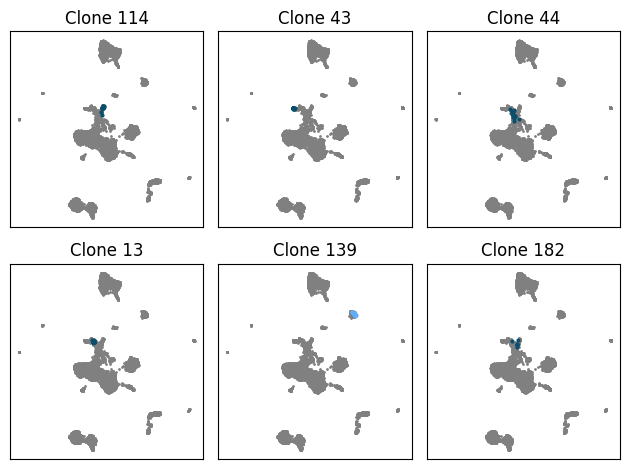

In [924]:
fig, ax = plt.subplots(2,3)

idxs = np.where(adata_for_plotting.obs['clone_id'] != '114_4')[0]
dot_size = tiny
ax[0][0].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='grey', label=key)
idxs = np.where(adata_for_plotting.obs['clone_id'] == '114_4')[0]
dot_size = biggus
ax[0][0].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='#0B4F6C', label=key)

idxs = np.where(adata_for_plotting.obs['clone_id'] != '43_3')[0]
dot_size = tiny
ax[0][1].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='grey', label=key)
idxs = np.where(adata_for_plotting.obs['clone_id'] == '43_4')[0]
dot_size = biggus
ax[0][1].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='#0B4F6C', label=key)


idxs = np.where(adata_for_plotting.obs['clone_id'] != '44_4')[0]
dot_size = tiny
ax[0][2].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='grey', label=key)
idxs = np.where(adata_for_plotting.obs['clone_id'] == '44_4')[0]
dot_size = biggus
ax[0][2].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='#0B4F6C', label=key)



idxs = np.where(adata_for_plotting.obs['clone_id'] != '13_6')[0]
dot_size = tiny
ax[1][0].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='grey', label=key)
idxs = np.where(adata_for_plotting.obs['clone_id'] == '13_6')[0]
dot_size = biggus
ax[1][0].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='#0B4F6C', label=key)


idxs = np.where(adata_for_plotting.obs['clone_id'] != '139_6')[0]
dot_size = tiny
ax[1][1].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='grey', label=key)
idxs = np.where(adata_for_plotting.obs['clone_id'] == '139_6')[0]
dot_size = biggus
ax[1][1].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='#60AFFF', label=key)


idxs = np.where(adata_for_plotting.obs['clone_id'] != '182_6')[0]
dot_size = tiny
ax[1][2].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='grey', label=key)
idxs = np.where(adata_for_plotting.obs['clone_id'] == '182_6')[0]
dot_size = biggus
ax[1][2].scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color='#0B4F6C', label=key)


ax[0][0].set_title('Clone 114')
ax[0][1].set_title('Clone 43')
ax[0][2].set_title('Clone 44')
ax[1][0].set_title('Clone 13')
ax[1][1].set_title('Clone 139')
ax[1][2].set_title('Clone 182')

for i in range(2):
    for j in range(3):
        ax[i][j].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,  
            left=False, # ticks along the top edge are off
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
plt.tight_layout()
plt.savefig('figures/Fig2D.pdf')
plt.show()

Gray
13344A>G
6253T>C
2926A>G
2860G>A
15003G>A
6221T>C
11814T>C
14836A>G
11307C>T
7056G>A
2470G>A
11742G>A


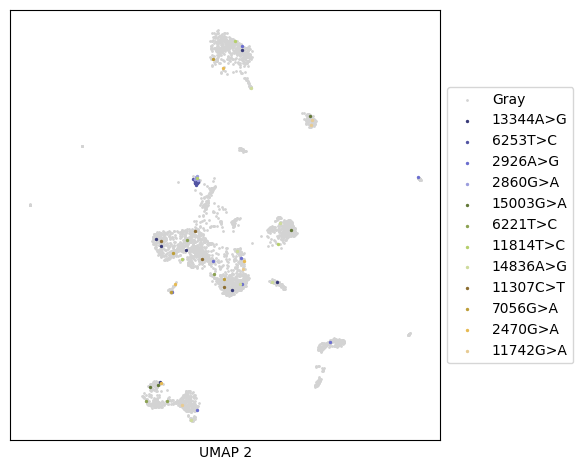

In [793]:

fig = plt.figure()
ax = plt.subplot(1, 1, 1)
for key, color in p_dict.items():
    print(key)
    idxs = np.where(adata_cospar.obs['clone_viz'] == key)[0]
    dot_size = 1 if key == 'Gray' else 2
    ax.scatter(x_emb[idxs],y_emb[idxs],s=dot_size, color=color, label=key)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left=False, # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax.set_xlabel('UMAP 1')
ax.set_xlabel('UMAP 2')
ax.set_box_aspect(1)
fig.tight_layout()
fig.savefig('figures/Supp_Fig_6_right.pdf')

In [402]:
import scanpy as sc

False
True


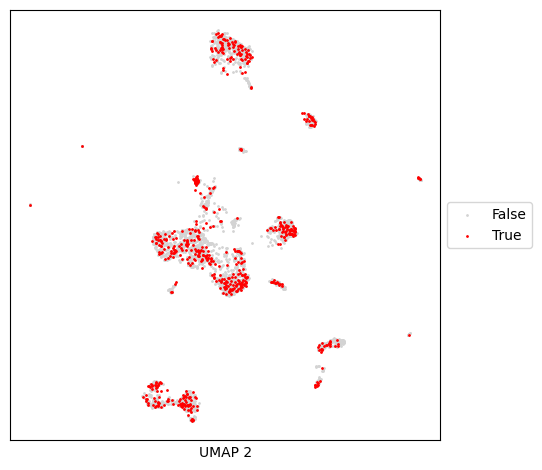

In [800]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
for key, color in {False: 'lightgrey',True: 'Red'}.items():
    print(key)
    idxs = np.where(adata_cospar.obs['Any Mutation'] == key)[0]
    dot_size = 1 if key == 'NA' else 2
    ax.scatter(x_emb[idxs],y_emb[idxs],s=1, color=color, label=key)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left=False, # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax.set_xlabel('UMAP 1')
ax.set_xlabel('UMAP 2')
ax.set_box_aspect(1)
fig.tight_layout()
fig.savefig('figures/Supp_Fig_6_left.pdf')

In [639]:
adata_cospar.obs['state_info'] = adata_cospar.obs['cell_annotation']

In [640]:
cs.tl.fate_coupling(
    adata_cospar, selected_fates=['gdT_2',
 'Naive CD4+ T',
 'Naive/CM CD4+ T_1',
 'Clonal CD4+ T',
 'CD4+ TCM/TEM',
 'Naive/CM CD4+ T_2',
 'gdT_1',
 'CD8+ TEM/CD4+ CTL',
 'Tregs',
 'Naive CD8+ T',
 'Naive/CM CD4/CD8+ T',
 'Clonal CD8+ T',
 'CD8+ TCM/TEM'], source="X_clone")  # compute the fate coupling

Results saved as dictionary at adata.uns['fate_coupling_X_clone']


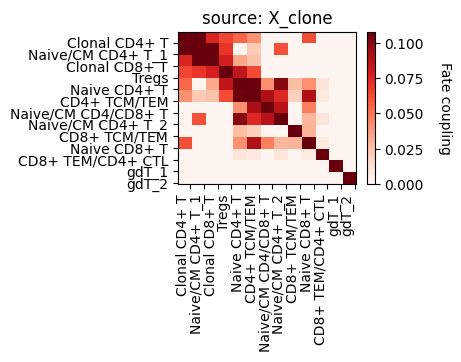

In [641]:
ax = cs.pl.fate_coupling(adata_cospar, source="X_clone")
plt.savefig('figures/Fig2L.pdf')
plt.show()